In [39]:
from core.toymdp import ToyMDP as ENV
import numpy as np
from tqdm import tqdm
from core.giope import GIOPE
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [35]:
# consrtants
h = 3 # horizon
n_trajectories = 50000
C = 1.0

In [29]:
X = np.zeros(n_trajectories)
y = np.zeros(n_trajectories)
w = np.zeros(n_trajectories)
for traj_id in tqdm(range(n_trajectories)):
    env = ENV(H=h)
    x0 = env.reset()
    terminal = False
    x = x0
    rho = 1
    R = 0
    while not terminal:
        x_p = x
        if x > 0.8:
            pb = [0.5, 0.25, 0.25]
        else:
            pb = [0.25, 0.25, 0.5]

        if x < 0.2:
            pe = [0.25, 0.25, 0.5]
        else:
            pe = [0.5, 0.25, 0.25]

        A_idx = np.random.choice(np.arange(3), p = pb)
        A = env.actions[A_idx]
        rho *= pe[A_idx]/pb[A_idx]
        x, r, terminal = env.step(A)
        R += r
    X[traj_id] = x0; y[traj_id] = R; w[traj_id]=rho

100%|██████████| 50000/50000 [00:09<00:00, 5116.47it/s]


In [36]:
def reg(t, sigma, alpha=0.0): 
    return np.maximum(0.0, alpha - (np.abs(t) - 1.0 * sigma))

test_data = pickle.load(open('data/h%d.pkl'%h, 'rb'))
truth = test_data['treatment_effect']
xspace = test_data['xspace']
clf = GIOPE(regularizer=reg, max_depth=1000, min_sample=20, compute_bootstrap=True,\
                               variance_type='upper_bound', function_max=float(h), 
                               C=C, wis=False)
clf.fit(X.reshape(-1, 1), y ,w, ['x'])
predicted_var = clf.predict(xspace.reshape(-1, 1), info=False)

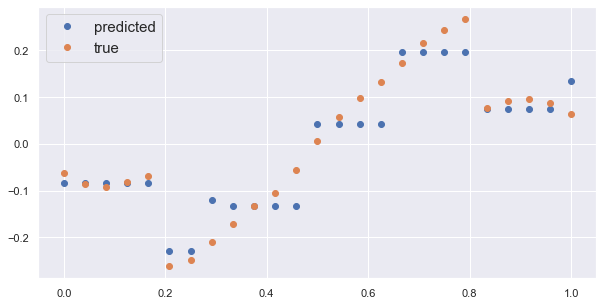

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(xspace, predicted_var, 'o', label='predicted')
plt.plot(xspace, truth, 'o', label='true')
plt.legend(fontsize=15)